In [ ]:
# Install required packages
!pip install requests beautifulsoup4 feedparser newspaper3k python-dotenv pandas matplotlib seaborn wordcloud pytrends
!pip install transformers torch sentence-transformers scikit-learn nltk textblob vaderSentiment openai-whisper groq
!pip install newsapi-python
!pip install lxml[html_clean]

In [ ]:
import requests
import json
import pandas as pd
import sqlite3
import time
import re
import numpy as np
import nltk
import feedparser
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime, timedelta
from urllib.parse import urlencode, quote_plus
from bs4 import BeautifulSoup
from newspaper import Article
from transformers import pipeline, AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

In [ ]:
# Foundation of the pipeline, ensures all signals are stored with rich metadata for downstream AI analysis
class EnhancedIntentSignalCollector:
    def __init__(self):
        self.signals = []
        self.detailed_signals = []  # For comprehensive CSV export
        self.setup_database()

    def setup_database(self):
        """Setup SQLite database with enhanced schema"""
        self.conn = sqlite3.connect('enhanced_intent_signals.db')
        self.cursor = self.conn.cursor()

        # Enhanced table with more fields for comprehensive data storage
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS signals (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                signal_type TEXT,
                company_name TEXT,
                signal_strength INTEGER,
                source TEXT,
                source_type TEXT,
                description TEXT,
                url TEXT,
                timestamp TEXT,
                collection_date TEXT,
                keyword TEXT,
                search_term TEXT,
                content_snippet TEXT,
                author TEXT,
                publication_date TEXT,
                engagement_score INTEGER,
                sentiment_score REAL,
                relevance_score INTEGER,
                geographic_location TEXT,
                industry_category TEXT,
                signal_context TEXT,
                raw_data TEXT,
                processing_notes TEXT,
                confidence_level REAL,
                follow_up_required BOOLEAN,
                priority_level TEXT,
                metadata TEXT
            )
        ''')
        self.conn.commit()

    def save_enhanced_signal(self, signal_data):
        """Save comprehensive signal data to both database and memory"""
        # Set defaults for missing fields
        defaults = {
            'signal_type': 'Unknown',
            'company_name': '',
            'signal_strength': 5,
            'source': '',
            'source_type': '',
            'description': '',
            'url': '',
            'timestamp': datetime.now().isoformat(),
            'collection_date': datetime.now().strftime('%Y-%m-%d'),
            'keyword': '',
            'search_term': '',
            'content_snippet': '',
            'author': '',
            'publication_date': '',
            'engagement_score': 0,
            'sentiment_score': 0.0,
            'relevance_score': 5,
            'geographic_location': '',
            'industry_category': '',
            'signal_context': '',
            'raw_data': '',
            'processing_notes': '',
            'confidence_level': 0.7,
            'follow_up_required': False,
            'priority_level': 'Medium',
            'metadata': {}
        }

        # Merge provided data with defaults
        signal = {**defaults, **signal_data}

        # Convert metadata to JSON string
        metadata_json = json.dumps(signal['metadata']) if signal['metadata'] else "{}"

        # Save to database
        self.cursor.execute('''
            INSERT INTO signals (
                signal_type, company_name, signal_strength, source, source_type,
                description, url, timestamp, collection_date, keyword, search_term,
                content_snippet, author, publication_date, engagement_score,
                sentiment_score, relevance_score, geographic_location,
                industry_category, signal_context, raw_data, processing_notes,
                confidence_level, follow_up_required, priority_level, metadata
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            signal['signal_type'], signal['company_name'], signal['signal_strength'],
            signal['source'], signal['source_type'], signal['description'], signal['url'],
            signal['timestamp'], signal['collection_date'], signal['keyword'],
            signal['search_term'], signal['content_snippet'], signal['author'],
            signal['publication_date'], signal['engagement_score'], signal['sentiment_score'],
            signal['relevance_score'], signal['geographic_location'], signal['industry_category'],
            signal['signal_context'], signal['raw_data'], signal['processing_notes'],
            signal['confidence_level'], signal['follow_up_required'], signal['priority_level'],
            metadata_json
        ))
        self.conn.commit()

        # Add to memory storage
        self.detailed_signals.append(signal)
        self.signals.append({  # Backward compatibility
            'signal_type': signal['signal_type'],
            'company_name': signal['company_name'],
            'signal_strength': signal['signal_strength'],
            'source': signal['source'],
            'description': signal['description'],
            'url': signal['url'],
            'timestamp': signal['timestamp'],
            'metadata': signal['metadata']
        })

        print(f"✅ Enhanced signal saved: {signal['signal_type']} - {signal['company_name']} (Strength: {signal['signal_strength']})")


In [ ]:
# Enhanced Google News Collector
class EnhancedGoogleNewsCollector:
    def __init__(self, collector):
        self.collector = collector

    def search_company_news(self, companies, keywords, days_back=7):
        """Enhanced Google News search with comprehensive data capture"""
        print("🔍 Collecting Enhanced Google News signals...")

        for company in companies:
            for keyword in keywords:
                try:
                    query = f'"{company}" AND "{keyword}"'
                    search_term = f"{company} {keyword}"
                    url = f"https://news.google.com/rss/search?q={quote_plus(query)}&hl=en&gl=US&ceid=US:en"

                    feed = feedparser.parse(url)

                    for entry in feed.entries[:5]:
                        pub_date = datetime(*entry.published_parsed[:6])
                        if (datetime.now() - pub_date).days <= days_back:

                            # Enhanced signal strength calculation
                            title_lower = entry.title.lower()
                            description_lower = entry.get('summary', '').lower()

                            strength = 5
                            confidence = 0.6
                            priority = "Medium"
                            context = ""

                            if any(word in title_lower for word in ['funding', 'raised', 'investment', 'series', 'venture']):
                                strength = 9
                                confidence = 0.9
                                priority = "High"
                                context = "Funding Event"
                            elif any(word in title_lower for word in ['hiring', 'expands', 'growth', 'acquisition']):
                                strength = 7
                                confidence = 0.8
                                priority = "High"
                                context = "Growth Signal"
                            elif any(word in title_lower for word in ['partnership', 'announces', 'launches']):
                                strength = 6
                                confidence = 0.7
                                priority = "Medium"
                                context = "Business Development"

                            # Calculate engagement score (placeholder - would use actual metrics in production)
                            engagement_score = len(entry.title) + len(entry.get('summary', '')) // 10

                            # Sentiment analysis (basic keyword-based)
                            positive_words = ['success', 'growth', 'expansion', 'achievement', 'breakthrough']
                            negative_words = ['decline', 'loss', 'problem', 'issue', 'challenge']
                            sentiment = sum(1 for word in positive_words if word in title_lower) - sum(1 for word in negative_words if word in title_lower)
                            sentiment_score = max(-1, min(1, sentiment / 5))

                            signal_data = {
                                'signal_type': "Topic Research Surge",
                                'company_name': company,
                                'signal_strength': strength,
                                'source': "Google News",
                                'source_type': "News Media",
                                'description': entry.title,
                                'url': entry.link,
                                'keyword': keyword,
                                'search_term': search_term,
                                'content_snippet': entry.get('summary', '')[:500],
                                'publication_date': entry.published,
                                'engagement_score': engagement_score,
                                'sentiment_score': sentiment_score,
                                'relevance_score': strength,
                                'signal_context': context,
                                'confidence_level': confidence,
                                'follow_up_required': strength >= 8,
                                'priority_level': priority,
                                'raw_data': json.dumps({
                                    'title': entry.title,
                                    'summary': entry.get('summary', ''),
                                    'published': entry.published,
                                    'link': entry.link
                                }),
                                'processing_notes': f"Auto-processed from Google News RSS feed on {datetime.now().strftime('%Y-%m-%d %H:%M')}",
                                'metadata': {
                                    'feed_source': 'google_news_rss',
                                    'search_query': query,
                                    'days_back': days_back,
                                    'entry_id': entry.get('id', ''),
                                    'tags': entry.get('tags', [])
                                }
                            }

                            self.collector.save_enhanced_signal(signal_data)

                    time.sleep(1)

                except Exception as e:
                    print(f"❌ Error fetching news for {company} + {keyword}: {e}")


In [ ]:
# Enhanced Reddit Collector
class EnhancedRedditCollector:
    def __init__(self, collector):
        self.collector = collector
        self.base_url = "https://www.reddit.com/search.json"

    def search_reddit_mentions(self, companies, keywords, subreddits=None):
        """Enhanced Reddit search with comprehensive data capture"""
        print("🔍 Collecting Enhanced Reddit signals...")

        if not subreddits:
            subreddits = ['entrepreneur', 'startups', 'business', 'technology', 'SaaS', 'marketing', 'sales']

        headers = {'User-Agent': 'IntentSignalBot/1.0'}

        for company in companies:
            for keyword in keywords:
                try:
                    for subreddit in subreddits:
                        query = f'"{company}" "{keyword}" subreddit:{subreddit}'
                        params = {
                            'q': query,
                            'sort': 'new',
                            't': 'week',
                            'limit': 10
                        }

                        response = requests.get(self.base_url, params=params, headers=headers)

                        if response.status_code == 200:
                            data = response.json()

                            for post in data.get('data', {}).get('children', []):
                                post_data = post.get('data', {})

                                # Enhanced metrics
                                score = post_data.get('score', 0)
                                comments = post_data.get('num_comments', 0)
                                upvote_ratio = post_data.get('upvote_ratio', 0.5)

                                # Calculate engagement score
                                engagement_score = score + (comments * 2)
                                strength = min(8, max(3, engagement_score // 10))

                                # Determine priority and context
                                title_lower = post_data.get('title', '').lower()
                                priority = "High" if engagement_score > 50 else "Medium" if engagement_score > 20 else "Low"

                                context = ""
                                if any(word in title_lower for word in ['recommendation', 'advice', 'help']):
                                    context = "Seeking Solutions"
                                elif any(word in title_lower for word in ['review', 'experience', 'thoughts']):
                                    context = "Product Evaluation"
                                elif any(word in title_lower for word in ['problem', 'issue', 'challenge']):
                                    context = "Pain Point Discussion"

                                signal_data = {
                                    'signal_type': "Forum or Social Chatter",
                                    'company_name': company,
                                    'signal_strength': strength,
                                    'source': f"Reddit - r/{subreddit}",
                                    'source_type': "Social Media",
                                    'description': post_data.get('title', ''),
                                    'url': f"https://reddit.com{post_data.get('permalink', '')}",
                                    'keyword': keyword,
                                    'search_term': f"{company} {keyword}",
                                    'content_snippet': post_data.get('selftext', '')[:500],
                                    'author': post_data.get('author', ''),
                                    'publication_date': datetime.fromtimestamp(post_data.get('created_utc', 0)).isoformat() if post_data.get('created_utc') else '',
                                    'engagement_score': engagement_score,
                                    'sentiment_score': (upvote_ratio - 0.5) * 2,  # Convert to -1 to 1 scale
                                    'relevance_score': strength,
                                    'signal_context': context,
                                    'confidence_level': min(0.9, 0.5 + (engagement_score / 100)),
                                    'follow_up_required': engagement_score > 30,
                                    'priority_level': priority,
                                    'raw_data': json.dumps(post_data),
                                    'processing_notes': f"Reddit post from r/{subreddit} with {score} upvotes and {comments} comments",
                                    'metadata': {
                                        'subreddit': subreddit,
                                        'score': score,
                                        'comments': comments,
                                        'upvote_ratio': upvote_ratio,
                                        'post_id': post_data.get('id', ''),
                                        'flair': post_data.get('link_flair_text', ''),
                                        'gilded': post_data.get('gilded', 0),
                                        'over_18': post_data.get('over_18', False)
                                    }
                                }

                                self.collector.save_enhanced_signal(signal_data)

                        time.sleep(2)

                except Exception as e:
                    print(f"❌ Error fetching Reddit data for {company} + {keyword}: {e}")


In [ ]:
# Enhanced Job Posting Collector
class EnhancedJobPostingCollector:
    def __init__(self, collector):
        self.collector = collector

    def search_job_postings(self, companies, tech_keywords):
        """Enhanced job posting search with comprehensive data capture"""
        print("🔍 Collecting Enhanced Job Posting signals...")

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        for company in companies:
            for keyword in tech_keywords:
                try:
                    params = {
                        'q': f'"{keyword}"',
                        'l': company,
                        'fromage': '7',
                        'limit': '10'
                    }

                    search_url = f"https://www.indeed.com/jobs?{urlencode(params)}"

                    response = requests.get(search_url, headers=headers)

                    if response.status_code == 200:
                        soup = BeautifulSoup(response.content, 'html.parser')
                        job_cards = soup.find_all('div', {'class': re.compile('job_seen_beacon')})

                        if job_cards:
                            for job_card in job_cards[:3]:
                                title_elem = job_card.find('h2', {'class': 'jobTitle'})
                                company_elem = job_card.find('span', {'class': 'companyName'})
                                location_elem = job_card.find('div', {'class': 'companyLocation'})
                                salary_elem = job_card.find('span', {'class': 'salaryText'})

                                if title_elem and company_elem:
                                    job_title = title_elem.get_text(strip=True)
                                    job_company = company_elem.get_text(strip=True)
                                    location = location_elem.get_text(strip=True) if location_elem else ''
                                    salary = salary_elem.get_text(strip=True) if salary_elem else ''

                                    # Enhanced strength calculation
                                    title_lower = job_title.lower()
                                    strength = 6
                                    priority = "Medium"
                                    context = "Standard Hiring"

                                    if any(word in title_lower for word in ['senior', 'lead', 'principal', 'director', 'head']):
                                        strength = 8
                                        priority = "High"
                                        context = "Senior Role Hiring"
                                    elif any(word in title_lower for word in ['manager', 'supervisor']):
                                        strength = 7
                                        priority = "Medium"
                                        context = "Management Hiring"
                                    elif any(word in title_lower for word in ['architect', 'specialist', 'expert']):
                                        strength = 7
                                        priority = "High"
                                        context = "Specialized Role Hiring"

                                    # Calculate engagement score based on job attributes
                                    engagement_score = 10
                                    if salary:
                                        engagement_score += 5
                                    if any(word in title_lower for word in ['remote', 'hybrid']):
                                        engagement_score += 3

                                    signal_data = {
                                        'signal_type': "Job Postings",
                                        'company_name': job_company,
                                        'signal_strength': strength,
                                        'source': "Indeed",
                                        'source_type': "Job Board",
                                        'description': f"Job posting: {job_title}",
                                        'url': search_url,
                                        'keyword': keyword,
                                        'search_term': f"{keyword} {company}",
                                        'content_snippet': f"Position: {job_title} | Company: {job_company} | Location: {location} | Salary: {salary}",
                                        'geographic_location': location,
                                        'engagement_score': engagement_score,
                                        'relevance_score': strength,
                                        'signal_context': context,
                                        'confidence_level': 0.8,
                                        'follow_up_required': strength >= 8,
                                        'priority_level': priority,
                                        'raw_data': json.dumps({
                                            'job_title': job_title,
                                            'company': job_company,
                                            'location': location,
                                            'salary': salary,
                                            'search_keyword': keyword
                                        }),
                                        'processing_notes': f"Job posting found on Indeed for {keyword} technology",
                                        'metadata': {
                                            'job_title': job_title,
                                            'location': location,
                                            'salary_info': salary,
                                            'search_company': company,
                                            'job_board': 'indeed',
                                            'posting_freshness': '7_days'
                                        }
                                    }

                                    self.collector.save_enhanced_signal(signal_data)

                    time.sleep(3)

                except Exception as e:
                    print(f"❌ Error fetching job postings for {company} + {keyword}: {e}")

In [ ]:
# Enhanced Analytics and Reporting
class EnhancedSignalAnalyzer:
    def __init__(self, collector):
        self.collector = collector

    def export_comprehensive_csv(self, filename="comprehensive_intent_signals.csv"):
        """Export all collected data to a comprehensive CSV file"""
        if not self.collector.detailed_signals:
            print("❌ No detailed signals to export")
            return

        # Create comprehensive DataFrame
        df = pd.DataFrame(self.collector.detailed_signals)

        # Add calculated fields
        df['days_since_collection'] = (datetime.now() - pd.to_datetime(df['timestamp'])).dt.days
        df['signal_priority_score'] = df['signal_strength'] * df['confidence_level']
        df['needs_immediate_action'] = (df['signal_strength'] >= 8) & (df['follow_up_required'] == True)

        # Reorder columns for better readability
        column_order = [
            'collection_date', 'timestamp', 'signal_type', 'company_name',
            'signal_strength', 'priority_level', 'confidence_level',
            'follow_up_required', 'needs_immediate_action',
            'source', 'source_type', 'description', 'url',
            'keyword', 'search_term', 'content_snippet',
            'author', 'publication_date', 'engagement_score',
            'sentiment_score', 'relevance_score',
            'geographic_location', 'industry_category', 'signal_context',
            'processing_notes', 'signal_priority_score', 'days_since_collection',
            'raw_data', 'metadata'
        ]

        # Reorder columns (keep any additional columns that might exist)
        existing_columns = [col for col in column_order if col in df.columns]
        remaining_columns = [col for col in df.columns if col not in column_order]
        final_columns = existing_columns + remaining_columns

        df = df[final_columns]

        # Export to CSV
        df.to_csv(filename, index=False, encoding='utf-8')

        print(f"✅ Comprehensive data exported to {filename}")
        print(f"📊 Total records: {len(df)}")
        print(f"📈 Columns included: {len(df.columns)}")
        print(f"🚨 High priority signals: {len(df[df['needs_immediate_action'] == True])}")

        # Display sample of the data
        print(f"\n📋 Sample of exported data:")
        print(df[['company_name', 'signal_type', 'signal_strength', 'priority_level', 'description']].head())

        return df

    def generate_enhanced_report(self):
        """Generate comprehensive analytics report"""
        if not self.collector.detailed_signals:
            print("❌ No signals collected yet!")
            return

        df = pd.DataFrame(self.collector.detailed_signals)

        print("\n" + "="*80)
        print("🎯 COMPREHENSIVE INTENT SIGNAL ANALYSIS REPORT")
        print("="*80)

        # Enhanced statistics
        total_signals = len(df)
        unique_companies = df['company_name'].nunique()
        avg_strength = df['signal_strength'].mean()
        avg_confidence = df['confidence_level'].mean()
        high_priority_count = len(df[df['follow_up_required'] == True])

        print(f"\n📊 OVERVIEW:")
        print(f"Total Signals Collected: {total_signals}")
        print(f"Unique Companies: {unique_companies}")
        print(f"Average Signal Strength: {avg_strength:.1f}/10")
        print(f"Average Confidence Level: {avg_confidence:.2f}")
        print(f"High Priority Signals: {high_priority_count} ({high_priority_count/total_signals*100:.1f}%)")

        # Priority breakdown
        print(f"\n🎯 PRIORITY BREAKDOWN:")
        priority_counts = df['priority_level'].value_counts()
        for priority, count in priority_counts.items():
            percentage = count/total_signals*100
            print(f"  {priority}: {count} signals ({percentage:.1f}%)")

        # Source analysis
        print(f"\n📡 SOURCE ANALYSIS:")
        source_counts = df['source_type'].value_counts()
        for source, count in source_counts.items():
            avg_strength = df[df['source_type'] == source]['signal_strength'].mean()
            print(f"  {source}: {count} signals (avg strength: {avg_strength:.1f})")

        # Top performing companies
        print(f"\n🏢 TOP COMPANIES BY SIGNAL STRENGTH:")
        company_performance = df.groupby('company_name').agg({
            'signal_strength': 'mean',
            'confidence_level': 'mean',
            'follow_up_required': 'sum'
        }).round(2).sort_values('signal_strength', ascending=False).head(10)

        for company, data in company_performance.iterrows():
            print(f"  {company}: Strength {data['signal_strength']:.1f}, Confidence {data['confidence_level']:.2f}, Follow-ups: {int(data['follow_up_required'])}")

    def create_enhanced_visualizations(self):
        """Create comprehensive visualization dashboard"""
        if not self.collector.detailed_signals:
            print("❌ No signals to visualize")
            return

        df = pd.DataFrame(self.collector.detailed_signals)

        fig, axes = plt.subplots(3, 2, figsize=(18, 15))

        # 1. Signal strength vs confidence level scatter
        axes[0,0].scatter(df['signal_strength'], df['confidence_level'], alpha=0.6, c=df['signal_strength'], cmap='viridis')
        axes[0,0].set_xlabel('Signal Strength')
        axes[0,0].set_ylabel('Confidence Level')
        axes[0,0].set_title('Signal Strength vs Confidence Level')

        # 2. Priority level distribution
        priority_counts = df['priority_level'].value_counts()
        axes[0,1].pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Signal Priority Distribution')

        # 3. Source type effectiveness
        source_performance = df.groupby('source_type')['signal_strength'].mean().sort_values(ascending=True)
        axes[1,0].barh(range(len(source_performance)), source_performance.values)
        axes[1,0].set_yticks(range(len(source_performance)))
        axes[1,0].set_yticklabels(source_performance.index)
        axes[1,0].set_title('Average Signal Strength by Source Type')
        axes[1,0].set_xlabel('Average Signal Strength')

        # 4. Engagement score distribution
        axes[1,1].hist(df['engagement_score'], bins=20, alpha=0.7, color='orange')
        axes[1,1].set_xlabel('Engagement Score')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Engagement Score Distribution')

        # 5. Sentiment analysis
        axes[2,0].hist(df['sentiment_score'], bins=15, alpha=0.7, color='green')
        axes[2,0].set_xlabel('Sentiment Score (-1 to 1)')
        axes[2,0].set_ylabel('Frequency')
        axes[2,0].set_title('Sentiment Score Distribution')
        axes[2,0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

        # 6. Follow-up required by signal type
        followup_by_type = df.groupby('signal_type')['follow_up_required'].sum().sort_values(ascending=False)
        axes[2,1].bar(range(len(followup_by_type)), followup_by_type.values)
        axes[2,1].set_xticks(range(len(followup_by_type)))
        axes[2,1].set_xticklabels(followup_by_type.index, rotation=45, ha='right')
        axes[2,1].set_title('Follow-up Required by Signal Type')
        axes[2,1].set_ylabel('Count')

        plt.tight_layout()
        plt.show()


In [ ]:
# Enhanced Main Execution Function
def run_enhanced_intent_signal_collection():
    """Enhanced main function with comprehensive data collection and export"""

    print("🚀 Starting Enhanced Intent Signal Collection Pipeline")
    print("=" * 60)

    # Initialize enhanced collector
    collector = EnhancedIntentSignalCollector()

    # Configuration
    TARGET_COMPANIES = [
        "Shopify", "Stripe", "HubSpot", "Salesforce", "Slack",
        "Zoom", "Atlassian", "Asana", "Monday.com", "Notion",
        "Zendesk", "Intercom", "Mailchimp", "Canva", "Figma"
    ]

    KEYWORDS = [
        "CRM", "automation", "API", "integration", "analytics",
        "machine learning", "AI", "workflow", "productivity", "SaaS",
        "customer success", "sales enablement", "marketing automation"
    ]

    TECH_KEYWORDS = [
        "Python", "React", "Node.js", "AWS", "API", "GraphQL",
        "microservices", "DevOps", "machine learning", "data science",
        "Kubernetes", "Docker", "TypeScript", "MongoDB", "PostgreSQL"
    ]

    # Initialize enhanced collectors
    enhanced_google_news = EnhancedGoogleNewsCollector(collector)
    enhanced_reddit = EnhancedRedditCollector(collector)
    enhanced_jobs = EnhancedJobPostingCollector(collector)

    # Run enhanced collections with more comprehensive data capture
    print("\n🔄 Running enhanced data collection...")

    # 1. Enhanced Google News signals
    enhanced_google_news.search_company_news(TARGET_COMPANIES[:5], KEYWORDS[:5], days_back=14)

    # 2. Enhanced Reddit signals
    enhanced_reddit.search_reddit_mentions(TARGET_COMPANIES[:4], KEYWORDS[:4])

    # 3. Enhanced Job posting signals
    enhanced_jobs.search_job_postings(TARGET_COMPANIES[:3], TECH_KEYWORDS[:5])

    print(f"\n✅ Enhanced collection complete! Found {len(collector.detailed_signals)} comprehensive signals")

    # Generate enhanced analytics and export
    analyzer = EnhancedSignalAnalyzer(collector)

    # Export comprehensive CSV with all data
    comprehensive_df = analyzer.export_comprehensive_csv("comprehensive_intent_signals.csv")

    # Generate detailed report
    analyzer.generate_enhanced_report()

    # Create visualizations
    analyzer.create_enhanced_visualizations()

    # Export additional specialized CSV files
    if comprehensive_df is not None:
        # High priority signals only
        high_priority = comprehensive_df[comprehensive_df['needs_immediate_action'] == True]
        if not high_priority.empty:
            high_priority.to_csv("high_priority_signals.csv", index=False)
            print(f"✅ High priority signals exported to high_priority_signals.csv ({len(high_priority)} records)")

        # Signals by source type
        for source_type in comprehensive_df['source_type'].unique():
            source_df = comprehensive_df[comprehensive_df['source_type'] == source_type]
            filename = f"signals_{source_type.lower().replace(' ', '_')}.csv"
            source_df.to_csv(filename, index=False)
            print(f"✅ {source_type} signals exported to {filename} ({len(source_df)} records)")

        # Company-specific exports for top companies
        top_companies = comprehensive_df['company_name'].value_counts().head(5).index
        for company in top_companies:
            company_df = comprehensive_df[comprehensive_df['company_name'] == company]
            filename = f"signals_{company.lower().replace(' ', '_').replace('.', '')}.csv"
            company_df.to_csv(filename, index=False)
            print(f"✅ {company} signals exported to {filename} ({len(company_df)} records)")

    return collector, analyzer, comprehensive_df

In [ ]:
# Additional utility functions for data analysis
def analyze_signal_trends(df):
    """Analyze trends in signal data over time"""
    if df is None or df.empty:
        return

    print("\n📈 SIGNAL TRENDS ANALYSIS:")

    # Convert timestamp to datetime
    df['timestamp_dt'] = pd.to_datetime(df['timestamp'])
    df['collection_day'] = df['timestamp_dt'].dt.date

    # Daily signal counts
    daily_counts = df.groupby('collection_day').size()
    print(f"Daily Signal Counts:")
    for date, count in daily_counts.items():
        print(f"  {date}: {count} signals")

    # Trending companies (companies with increasing signal strength over time)
    company_trends = df.groupby(['company_name', 'collection_day'])['signal_strength'].mean().unstack(fill_value=0)

    if len(company_trends.columns) > 1:
        # Calculate trend (simple slope)
        for company in company_trends.index:
            values = company_trends.loc[company].values
            if len(values) > 1 and values[-1] > values[0]:
                trend = (values[-1] - values[0]) / len(values)
                if trend > 0.5:
                    print(f"📈 Trending UP: {company} (trend: +{trend:.1f})")


In [ ]:
def generate_action_items(df):
    """Generate actionable insights from signal data"""
    if df is None or df.empty:
        return

    print("\n🎯 RECOMMENDED ACTION ITEMS:")

    # Immediate follow-ups
    immediate_actions = df[df['needs_immediate_action'] == True].sort_values('signal_strength', ascending=False)
    if not immediate_actions.empty:
        print(f"\n🚨 IMMEDIATE ACTIONS REQUIRED ({len(immediate_actions)} items):")
        for _, signal in immediate_actions.head(10).iterrows():
            print(f"  • {signal['company_name']}: {signal['description'][:80]}...")
            print(f"    Strength: {signal['signal_strength']}/10, Source: {signal['source']}")
            print(f"    Action: {signal['signal_context']}")

    # Companies showing multiple signals (likely hot prospects)
    company_signal_counts = df.groupby('company_name').size().sort_values(ascending=False)
    hot_prospects = company_signal_counts[company_signal_counts >= 3].head(10)

    if not hot_prospects.empty:
        print(f"\n🔥 HOT PROSPECTS (Multiple Signals):")
        for company, count in hot_prospects.items():
            avg_strength = df[df['company_name'] == company]['signal_strength'].mean()
            latest_signal = df[df['company_name'] == company].sort_values('timestamp').iloc[-1]
            print(f"  • {company}: {count} signals, avg strength {avg_strength:.1f}")
            print(f"    Latest: {latest_signal['description'][:60]}...")

    # Signals by keyword (what technologies/topics are trending)
    keyword_analysis = df.groupby('keyword').agg({
        'signal_strength': 'mean',
        'company_name': 'nunique'
    }).sort_values('signal_strength', ascending=False)

    print(f"\n🔍 TRENDING KEYWORDS/TOPICS:")
    for keyword, data in keyword_analysis.head(10).iterrows():
        if keyword:  # Skip empty keywords
            print(f"  • {keyword}: {data['company_name']} companies, avg strength {data['signal_strength']:.1f}")

In [ ]:
def export_executive_summary(df, filename="executive_summary.csv"):
    """Create executive summary CSV for leadership"""
    if df is None or df.empty:
        return

    # Create summary data
    summary_data = []

    # Company summaries
    for company in df['company_name'].unique():
        company_df = df[df['company_name'] == company]

        summary = {
            'company_name': company,
            'total_signals': len(company_df),
            'avg_signal_strength': company_df['signal_strength'].mean(),
            'max_signal_strength': company_df['signal_strength'].max(),
            'high_priority_signals': len(company_df[company_df['priority_level'] == 'High']),
            'follow_up_required': len(company_df[company_df['follow_up_required'] == True]),
            'avg_confidence': company_df['confidence_level'].mean(),
            'primary_signal_types': ', '.join(company_df['signal_type'].value_counts().head(3).index.tolist()),
            'latest_signal_date': company_df['timestamp'].max(),
            'latest_signal_description': company_df.sort_values('timestamp').iloc[-1]['description'][:100],
            'recommendation': 'IMMEDIATE ACTION' if len(company_df[company_df['needs_immediate_action'] == True]) > 0
                           else 'HIGH PRIORITY' if company_df['signal_strength'].mean() >= 7
                           else 'MONITOR'
        }
        summary_data.append(summary)

    # Create summary DataFrame and export
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('avg_signal_strength', ascending=False)
    summary_df.to_csv(filename, index=False)

    print(f"✅ Executive summary exported to {filename}")
    return summary_df

In [ ]:
# Run Intent Signal Collection Pipeline
if __name__ == "__main__":
    collector, analyzer, comprehensive_df = run_enhanced_intent_signal_collection()

    # Additional analysis
    if comprehensive_df is not None:
        analyze_signal_trends(comprehensive_df)
        generate_action_items(comprehensive_df)
        executive_summary = export_executive_summary(comprehensive_df)

        print(f"\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"📁 Files generated:")
        print(f"  • comprehensive_intent_signals.csv - Complete dataset")
        print(f"  • high_priority_signals.csv - Urgent follow-ups")
        print(f"  • executive_summary.csv - Leadership overview")
        print(f"  • Source-specific CSV files")
        print(f"  • Company-specific CSV files")
        print(f"\n💡 Next steps: Review high priority signals and executive summary for immediate actions!")

In [ ]:
class AgenticIntentAnalyzer:
    """
    AI-powered agentic module for intelligent intent signal analysis
    """

    def __init__(self, collector):
        self.collector = collector
        self.setup_ai_models()
        self.knowledge_base = self.build_knowledge_base()
        self.decision_engine = DecisionEngine()
        self.autonomous_actions = []

    def setup_ai_models(self):
        """Initialize pre-trained AI models for analysis"""
        print("🤖 Initializing AI models...")

        try:
            # Sentiment analysis pipeline
            self.sentiment_analyzer = pipeline(
                "sentiment-analysis",
                model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                truncation=True,
                max_length=512
            )

            # Text classification for intent detection
            self.intent_classifier = pipeline(
                "zero-shot-classification",
                model="facebook/bart-large-mnli"
            )

            # Sentence embeddings for similarity analysis
            self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

            # Named Entity Recognition
            self.ner_pipeline = pipeline(
                "ner",
                model="dbmdz/bert-large-cased-finetuned-conll03-english",
                aggregation_strategy="simple"
            )

            # VADER sentiment for backup
            self.vader = SentimentIntensityAnalyzer()

            print("✅ AI models loaded successfully")

        except Exception as e:
            print(f"⚠️ Error loading some AI models: {e}")
            # Fallback to basic models
            self.setup_fallback_models()

    def setup_fallback_models(self):
        """Setup basic models if advanced ones fail"""
        try:
            self.sentiment_analyzer = pipeline("sentiment-analysis")
            self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
            self.vader = SentimentIntensityAnalyzer()
            print("✅ Fallback models loaded")
        except Exception as e:
            print(f"❌ Critical error loading models: {e}")

    def build_knowledge_base(self):
        """Build knowledge base of company and technology patterns"""
        return {
            'buying_signals': [
                'looking for', 'need help with', 'recommendation', 'comparison',
                'evaluation', 'budget', 'procurement', 'vendor selection',
                'implementation', 'migration', 'upgrade', 'replace'
            ],
            'pain_points': [
                'problem', 'issue', 'challenge', 'struggling', 'difficult',
                'frustrated', 'broken', 'not working', 'slow', 'expensive'
            ],
            'positive_indicators': [
                'funding', 'investment', 'growth', 'expansion', 'hiring',
                'success', 'achievement', 'breakthrough', 'launch', 'partnership'
            ],
            'urgency_indicators': [
                'urgent', 'asap', 'immediately', 'deadline', 'critical',
                'emergency', 'priority', 'time-sensitive', 'soon'
            ],
            'company_stages': {
                'startup': ['seed', 'series a', 'early stage', 'founding', 'mvp'],
                'growth': ['series b', 'series c', 'scaling', 'expansion', 'growing'],
                'enterprise': ['established', 'fortune', 'large', 'enterprise', 'corporate']
            },
            'tech_categories': {
                'crm': ['salesforce', 'hubspot', 'pipedrive', 'customer relationship'],
                'marketing': ['mailchimp', 'marketo', 'automation', 'campaign'],
                'productivity': ['slack', 'asana', 'monday', 'workflow', 'collaboration'],
                'development': ['github', 'jira', 'devops', 'api', 'integration'],
                'analytics': ['tableau', 'looker', 'dashboard', 'reporting', 'metrics']
            }
        }


In [ ]:
class DecisionEngine:
    """
    Autonomous decision-making engine for intent signals
    """

    def __init__(self):
        self.decision_rules = self.setup_decision_rules()
        self.action_templates = self.setup_action_templates()

    def setup_decision_rules(self):
        """Define AI-driven decision rules"""
        return {
            'immediate_action': {
                'conditions': ['signal_strength >= 8', 'urgency_score > 0.7', 'buying_intent > 0.8'],
                'action': 'schedule_immediate_outreach'
            },
            'high_priority': {
                'conditions': ['signal_strength >= 6', 'company_fit_score > 0.7'],
                'action': 'add_to_priority_queue'
            },
            'nurture': {
                'conditions': ['signal_strength >= 4', 'engagement_potential > 0.5'],
                'action': 'add_to_nurture_campaign'
            },
            'research_needed': {
                'conditions': ['confidence_level < 0.6', 'entity_clarity < 0.5'],
                'action': 'schedule_research_task'
            }
        }

    def setup_action_templates(self):
        """Define automated action templates"""
        return {
            'email_outreach': {
                'subject_templates': [
                    "Saw your {signal_context} - here's how we can help",
                    "Quick question about your {technology} implementation",
                    "{company_name} + {our_solution} = potential partnership?"
                ],
                'personalization_points': [
                    'recent_signal', 'company_stage', 'tech_stack', 'pain_points'
                ]
            },
            'content_recommendation': {
                'case_studies': 'based on similar company profiles',
                'whitepapers': 'matching technology interests',
                'demos': 'relevant to identified use cases'
            },
            'follow_up_cadence': {
                'immediate': [1, 3, 7],  # days
                'high_priority': [3, 7, 14],
                'nurture': [7, 14, 30]
            }
        }


In [ ]:
class AgenticProcessor:
    """
    Main agentic processing engine
    """

    def __init__(self, analyzer):
        self.analyzer = analyzer
        self.processed_signals = []
        self.autonomous_insights = []

    def analyze_signal_with_ai(self, signal):
        """Comprehensive AI analysis of a single signal"""
        enhanced_signal = signal.copy()

        try:
            # Extract text for analysis
            text_content = f"{signal.get('description', '')} {signal.get('content_snippet', '')}"

            # AI-powered sentiment analysis
            sentiment_result = self.analyzer.sentiment_analyzer(text_content[:512])
            enhanced_signal['ai_sentiment'] = sentiment_result[0]['label']
            enhanced_signal['ai_sentiment_score'] = sentiment_result[0]['score']

            # VADER sentiment as backup
            vader_scores = self.analyzer.vader.polarity_scores(text_content)
            enhanced_signal['vader_sentiment'] = vader_scores

            # Intent classification
            intent_labels = [
                'buying intent', 'research intent', 'comparison shopping',
                'problem solving', 'vendor evaluation', 'technology adoption'
            ]
            intent_result = self.analyzer.intent_classifier(text_content[:512], intent_labels)
            enhanced_signal['primary_intent'] = intent_result['labels'][0]
            enhanced_signal['intent_confidence'] = intent_result['scores'][0]

            # Named Entity Recognition
            entities = self.analyzer.ner_pipeline(text_content[:512])
            enhanced_signal['entities'] = [
                {'text': ent['word'], 'label': ent['entity_group'], 'confidence': ent['score']}
                for ent in entities if ent['score'] > 0.7
            ]

            # Knowledge base matching
            enhanced_signal.update(self.match_knowledge_patterns(text_content))

            # Calculate AI-driven scores
            enhanced_signal.update(self.calculate_ai_scores(enhanced_signal))

            return enhanced_signal

        except Exception as e:
            print(f"⚠️ Error in AI analysis: {e}")
            return enhanced_signal

    def match_knowledge_patterns(self, text):
        """Match text against knowledge base patterns"""
        text_lower = text.lower()
        kb = self.analyzer.knowledge_base

        # Buying signals detection
        buying_signals = sum(1 for signal in kb['buying_signals'] if signal in text_lower)
        buying_intent_score = min(1.0, buying_signals / 3)

        # Pain points detection
        pain_points = [point for point in kb['pain_points'] if point in text_lower]
        pain_score = min(1.0, len(pain_points) / 2)

        # Urgency detection
        urgency_indicators = [ind for ind in kb['urgency_indicators'] if ind in text_lower]
        urgency_score = min(1.0, len(urgency_indicators) / 2)

        # Company stage detection
        detected_stage = 'unknown'
        for stage, keywords in kb['company_stages'].items():
            if any(keyword in text_lower for keyword in keywords):
                detected_stage = stage
                break

        # Technology category detection
        tech_interests = []
        for category, keywords in kb['tech_categories'].items():
            if any(keyword in text_lower for keyword in keywords):
                tech_interests.append(category)

        return {
            'buying_intent_score': buying_intent_score,
            'pain_score': pain_score,
            'urgency_score': urgency_score,
            'detected_company_stage': detected_stage,
            'technology_interests': tech_interests,
            'matched_pain_points': pain_points,
            'urgency_indicators': urgency_indicators
        }

    def calculate_ai_scores(self, signal):
        """Calculate comprehensive AI-driven scores"""
        # Company fit score (based on multiple factors)
        company_fit_factors = [
            signal.get('buying_intent_score', 0) * 0.3,
            signal.get('intent_confidence', 0) * 0.2,
            signal.get('ai_sentiment_score', 0) * 0.2,
            (1 if signal.get('detected_company_stage') != 'unknown' else 0) * 0.15,
            (len(signal.get('technology_interests', [])) / 5) * 0.15
        ]
        company_fit_score = sum(company_fit_factors)

        # Engagement potential (likelihood of positive response)
        engagement_factors = [
            signal.get('urgency_score', 0) * 0.25,
            signal.get('pain_score', 0) * 0.25,
            signal.get('buying_intent_score', 0) * 0.3,
            (signal.get('engagement_score', 0) / 100) * 0.2
        ]
        engagement_potential = sum(engagement_factors)

        # Entity clarity (how well we understand the signal)
        entity_clarity = len(signal.get('entities', [])) / 5 if signal.get('entities') else 0.3

        # Composite priority score
        priority_score = (
            signal.get('signal_strength', 5) * 0.3 +
            company_fit_score * 10 * 0.25 +
            engagement_potential * 10 * 0.25 +
            signal.get('confidence_level', 0.5) * 10 * 0.2
        )

        return {
            'company_fit_score': round(company_fit_score, 3),
            'engagement_potential': round(engagement_potential, 3),
            'entity_clarity': round(entity_clarity, 3),
            'ai_priority_score': round(priority_score, 2)
        }

    def make_autonomous_decisions(self, enhanced_signal):
        """Make autonomous decisions based on AI analysis"""
        decisions = []
        rules = self.analyzer.decision_engine.decision_rules

        for rule_name, rule in rules.items():
            if self.evaluate_conditions(enhanced_signal, rule['conditions']):
                decisions.append({
                    'rule': rule_name,
                    'action': rule['action'],
                    'confidence': enhanced_signal.get('ai_priority_score', 5) / 10,
                    'reasoning': self.generate_reasoning(enhanced_signal, rule_name)
                })

        return decisions

    def evaluate_conditions(self, signal, conditions):
        """Evaluate rule conditions against signal data"""
        for condition in conditions:
            try:
                # Parse condition (e.g., 'signal_strength >= 8')
                parts = condition.replace('>=', '|>=|').replace('>', '|>|').replace('<', '|<|').replace('==', '|==|')
                for op in ['|>=|', '|>|', '|<|', '|==|']:
                    if op in parts:
                        field, operator, value = parts.split(op)
                        field = field.strip()
                        value = float(value.strip())
                        signal_value = signal.get(field, 0)

                        if operator == '|>=|' and signal_value >= value:
                            continue
                        elif operator == '|>|' and signal_value > value:
                            continue
                        elif operator == '|<|' and signal_value < value:
                            continue
                        elif operator == '|==|' and signal_value == value:
                            continue
                        else:
                            return False
            except:
                continue
        return True

    def generate_reasoning(self, signal, rule_name):
        """Generate human-readable reasoning for decisions"""
        reasoning_templates = {
            'immediate_action': f"High signal strength ({signal.get('signal_strength', 0)}) with strong buying intent ({signal.get('buying_intent_score', 0):.2f}) and urgency indicators detected.",
            'high_priority': f"Good company fit ({signal.get('company_fit_score', 0):.2f}) with solid signal strength ({signal.get('signal_strength', 0)}).",
            'nurture': f"Moderate engagement potential ({signal.get('engagement_potential', 0):.2f}) suggests nurturing opportunity.",
            'research_needed': f"Low confidence ({signal.get('confidence_level', 0):.2f}) requires additional research before action."
        }
        return reasoning_templates.get(rule_name, "Standard processing rule applied.")



In [ ]:
class AgenticReportGenerator:
    """
    Generate intelligent reports with AI insights
    """

    def __init__(self, processor):
        self.processor = processor

    def generate_ai_insights_report(self):
        """Generate comprehensive AI-powered insights report"""
        signals = self.processor.processed_signals

        if not signals:
            print("❌ No processed signals available for AI insights")
            return

        print("\n" + "="*80)
        print("🤖 AI-POWERED INTENT SIGNAL INSIGHTS REPORT")
        print("="*80)

        # AI Analysis Overview
        total_signals = len(signals)
        high_intent_signals = len([s for s in signals if s.get('buying_intent_score', 0) > 0.6])
        urgent_signals = len([s for s in signals if s.get('urgency_score', 0) > 0.5])

        print(f"\n🧠 AI ANALYSIS OVERVIEW:")
        print(f"Total Analyzed Signals: {total_signals}")
        print(f"High Buying Intent: {high_intent_signals} ({high_intent_signals/total_signals*100:.1f}%)")
        print(f"Urgent Signals: {urgent_signals} ({urgent_signals/total_signals*100:.1f}%)")

        # Intent Distribution
        intent_distribution = defaultdict(int)
        for signal in signals:
            intent = signal.get('primary_intent', 'unknown')
            intent_distribution[intent] += 1

        print(f"\n🎯 INTENT DISTRIBUTION:")
        for intent, count in sorted(intent_distribution.items(), key=lambda x: x[1], reverse=True):
            percentage = count/total_signals*100
            print(f"  {intent}: {count} signals ({percentage:.1f}%)")

        # Sentiment Analysis
        sentiment_scores = [s.get('ai_sentiment_score', 0.5) for s in signals]
        avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        positive_sentiment = len([s for s in signals if s.get('ai_sentiment') == 'POSITIVE'])

        print(f"\n😊 SENTIMENT ANALYSIS:")
        print(f"Average Sentiment Score: {avg_sentiment:.3f}")
        print(f"Positive Sentiment: {positive_sentiment} signals ({positive_sentiment/total_signals*100:.1f}%)")

        # Company Fit Analysis
        fit_scores = [s.get('company_fit_score', 0) for s in signals]
        high_fit_companies = [s for s in signals if s.get('company_fit_score', 0) > 0.7]

        print(f"\n🏢 COMPANY FIT ANALYSIS:")
        print(f"Average Company Fit Score: {sum(fit_scores)/len(fit_scores):.3f}")
        print(f"High-Fit Companies: {len(high_fit_companies)}")

        # Top AI-Recommended Actions
        all_decisions = []
        for signal in signals:
            if 'autonomous_decisions' in signal:
                all_decisions.extend(signal['autonomous_decisions'])

        if all_decisions:
            action_counts = defaultdict(int)
            for decision in all_decisions:
                action_counts[decision['action']] += 1

            print(f"\n🤖 TOP AI-RECOMMENDED ACTIONS:")
            for action, count in sorted(action_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {action}: {count} recommendations")

        # Technology Interest Trends
        all_tech_interests = []
        for signal in signals:
            all_tech_interests.extend(signal.get('technology_interests', []))

        if all_tech_interests:
            tech_counter = Counter(all_tech_interests)
            print(f"\n💻 TRENDING TECHNOLOGY INTERESTS:")
            for tech, count in tech_counter.most_common(5):
                print(f"  {tech}: {count} mentions")

        return self.generate_actionable_recommendations(signals)

    def generate_actionable_recommendations(self, signals):
        """Generate specific actionable recommendations"""
        print(f"\n🎯 AI-GENERATED ACTIONABLE RECOMMENDATIONS:")

        # Immediate action items
        immediate_actions = []
        high_priority_items = []
        research_items = []

        for signal in signals:
            decisions = signal.get('autonomous_decisions', [])
            for decision in decisions:
                item = {
                    'company': signal.get('company_name', 'Unknown'),
                    'description': signal.get('description', '')[:60] + '...',
                    'action': decision['action'],
                    'confidence': decision['confidence'],
                    'reasoning': decision['reasoning']
                }

                if decision['action'] == 'schedule_immediate_outreach':
                    immediate_actions.append(item)
                elif decision['action'] == 'add_to_priority_queue':
                    high_priority_items.append(item)
                elif decision['action'] == 'schedule_research_task':
                    research_items.append(item)

        # Display recommendations
        if immediate_actions:
            print(f"\n🚨 IMMEDIATE ACTIONS ({len(immediate_actions)} items):")
            for item in sorted(immediate_actions, key=lambda x: x['confidence'], reverse=True)[:5]:
                print(f"  • {item['company']}: {item['description']}")
                print(f"    Action: {item['action']} (Confidence: {item['confidence']:.2f})")
                print(f"    Reasoning: {item['reasoning']}")

        if high_priority_items:
            print(f"\n⭐ HIGH PRIORITY QUEUE ({len(high_priority_items)} items):")
            for item in sorted(high_priority_items, key=lambda x: x['confidence'], reverse=True)[:5]:
                print(f"  • {item['company']}: {item['description']}")

        if research_items:
            print(f"\n🔍 RESEARCH REQUIRED ({len(research_items)} items):")
            for item in research_items[:3]:
                print(f"  • {item['company']}: {item['description']}")

        return {
            'immediate_actions': immediate_actions,
            'high_priority': high_priority_items,
            'research_needed': research_items
        }


In [ ]:
def run_agentic_analysis():
    """
    Main agentic analysis function
    """
    print("🚀 Starting Agentic Intent Signal Analysis...")
    print("="*60)

    # Check if we have collected signals
    if not hasattr(globals().get('collector'), 'detailed_signals') or not collector.detailed_signals:
        print("❌ No signals found. Please run the data collection pipeline first.")
        return None

    # Initialize agentic components
    print("🤖 Initializing AI-powered analysis components...")
    agentic_analyzer = AgenticIntentAnalyzer(collector)
    agentic_processor = AgenticProcessor(agentic_analyzer)

    # Process each signal with AI
    print(f"🔄 Processing {len(collector.detailed_signals)} signals with AI...")

    for i, signal in enumerate(collector.detailed_signals):
        print(f"  Processing signal {i+1}/{len(collector.detailed_signals)}: {signal.get('company_name', 'Unknown')}")

        # AI analysis
        enhanced_signal = agentic_processor.analyze_signal_with_ai(signal)

        # Autonomous decision making
        decisions = agentic_processor.make_autonomous_decisions(enhanced_signal)
        enhanced_signal['autonomous_decisions'] = decisions

        # Store processed signal
        agentic_processor.processed_signals.append(enhanced_signal)

    print(f"✅ AI analysis complete! Processed {len(agentic_processor.processed_signals)} signals")

    # Generate AI insights report
    report_generator = AgenticReportGenerator(agentic_processor)
    recommendations = report_generator.generate_ai_insights_report()

    # Export AI-enhanced data
    export_ai_enhanced_data(agentic_processor.processed_signals)

    return agentic_processor, recommendations


In [ ]:
def export_ai_enhanced_data(processed_signals):
    """Export AI-enhanced signal data"""
    if not processed_signals:
        return

    # Create enhanced DataFrame
    enhanced_df = pd.DataFrame(processed_signals)

    # Flatten nested data for CSV export
    for idx, row in enhanced_df.iterrows():
        # Flatten entities
        if 'entities' in row and row['entities']:
            entity_texts = [ent['text'] for ent in row['entities']]
            enhanced_df.at[idx, 'extracted_entities'] = ', '.join(entity_texts)

        # Flatten autonomous decisions
        if 'autonomous_decisions' in row and row['autonomous_decisions']:
            decision_actions = [dec['action'] for dec in row['autonomous_decisions']]
            enhanced_df.at[idx, 'recommended_actions'] = ', '.join(decision_actions)

            # Get highest confidence decision
            best_decision = max(row['autonomous_decisions'], key=lambda x: x['confidence'])
            enhanced_df.at[idx, 'primary_recommendation'] = best_decision['action']
            enhanced_df.at[idx, 'recommendation_confidence'] = best_decision['confidence']
            enhanced_df.at[idx, 'ai_reasoning'] = best_decision['reasoning']

    # Export comprehensive AI-enhanced dataset
    enhanced_df.to_csv("ai_enhanced_intent_signals.csv", index=False, encoding='utf-8')
    print(f"✅ AI-enhanced data exported to ai_enhanced_intent_signals.csv")

    # Export action-specific datasets
    immediate_actions = enhanced_df[enhanced_df['recommended_actions'].str.contains('immediate_outreach', na=False)]
    if not immediate_actions.empty:
        immediate_actions.to_csv("immediate_action_signals.csv", index=False)
        print(f"✅ Immediate action signals exported ({len(immediate_actions)} records)")

    high_priority = enhanced_df[enhanced_df['recommended_actions'].str.contains('priority_queue', na=False)]
    if not high_priority.empty:
        high_priority.to_csv("high_priority_queue.csv", index=False)
        print(f"✅ High priority queue exported ({len(high_priority)} records)")

    return enhanced_df


In [ ]:
def create_ai_dashboard():
    """Create interactive AI insights dashboard"""
    if not hasattr(globals().get('collector'), 'detailed_signals'):
        print("❌ No data available for dashboard")
        return

    # This would create visualizations of AI insights
    print("📊 Creating AI Insights Dashboard...")

    # Load processed data
    try:
        df = pd.read_csv("ai_enhanced_intent_signals.csv")

        # Create enhanced visualizations
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # AI Sentiment Distribution
        sentiment_counts = df['ai_sentiment'].value_counts()
        axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
        axes[0,0].set_title('AI Sentiment Analysis Distribution')

        # Buying Intent vs Company Fit
        axes[0,1].scatter(df['buying_intent_score'], df['company_fit_score'],
                         alpha=0.6, c=df['ai_priority_score'], cmap='viridis')
        axes[0,1].set_xlabel('Buying Intent Score')
        axes[0,1].set_ylabel('Company Fit Score')
        axes[0,1].set_title('Buying Intent vs Company Fit')

        # Intent Classification Distribution
        intent_counts = df['primary_intent'].value_counts().head(6)
        axes[0,2].bar(range(len(intent_counts)), intent_counts.values)
        axes[0,2].set_xticks(range(len(intent_counts)))
        axes[0,2].set_xticklabels(intent_counts.index, rotation=45, ha='right')
        axes[0,2].set_title('Primary Intent Classification')

        # AI Priority Score Distribution
        axes[1,0].hist(df['ai_priority_score'], bins=20, alpha=0.7, color='purple')
        axes[1,0].set_xlabel('AI Priority Score')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('AI Priority Score Distribution')

        # Engagement Potential vs Urgency
        axes[1,1].scatter(df['engagement_potential'], df['urgency_score'],
                         alpha=0.6, s=df['ai_priority_score']*10)
        axes[1,1].set_xlabel('Engagement Potential')
        axes[1,1].set_ylabel('Urgency Score')
        axes[1,1].set_title('Engagement Potential vs Urgency (Size = Priority)')

        # Recommendation Actions Distribution
        if 'primary_recommendation' in df.columns:
            rec_counts = df['primary_recommendation'].value_counts()
            axes[1,2].bar(range(len(rec_counts)), rec_counts.values, color='orange')
            axes[1,2].set_xticks(range(len(rec_counts)))
            axes[1,2].set_xticklabels(rec_counts.index, rotation=45, ha='right')
            axes[1,2].set_title('AI Recommended Actions')

        plt.tight_layout()
        plt.show()

        print("✅ AI Dashboard created successfully!")

    except Exception as e:
        print(f"❌ Error creating dashboard: {e}")


In [ ]:
# Main execution
if __name__ == "__main__":
    # Run the agentic analysis
    agentic_processor, ai_recommendations = run_agentic_analysis()

    # Create AI dashboard
    create_ai_dashboard()

    print(f"\n🎉 AGENTIC ANALYSIS COMPLETED!")
    print(f"📁 AI-Enhanced files generated:")
    print(f"  • ai_enhanced_intent_signals.csv - Complete AI analysis")
    print(f"  • immediate_action_signals.csv - Urgent follow-ups")
    print(f"  • high_priority_queue.csv - Priority prospects")
    print(f"\n🤖 The AI agent has analyzed your signals and made autonomous recommendations!")
    print(f"💡 Check the immediate action items for urgent follow-ups!")

| **Component**                           | **Class/Function Name**                              | **Key Methods / Features**                                                                                          | **Purpose in Pipeline**                                                                                  |
| --------------------------------------- | ---------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------- |
| 🏗️ **Data Storage & Management**       | `EnhancedIntentSignalCollector`                      | - `setup_database()` creates 26-field schema<br>- `save_enhanced_signal()` stores data with validation and metadata | Foundation of the pipeline, ensures all signals are stored with rich metadata for downstream AI analysis |
| 📰 **News Signal Collector**            | `EnhancedGoogleNewsCollector`                        | - Parses Google News RSS feeds<br>- Calculates signal strength, context & sentiment                                 | Detects early public intent such as funding, partnerships, or expansion—key buying triggers              |
| 🗣️ **Reddit Signal Collector**         | `EnhancedRedditCollector`                            | - Searches relevant subreddits<br>- Scores engagement, sentiment & context                                          | Captures informal chatter, pain points, or evaluation hints from prospects unaware of your solution      |
| 💼 **Job Posting Collector**            | `EnhancedJobPostingCollector`                        | - Scrapes job sites<br>- Extracts roles, location, salary, tech keywords                                            | Reveals hiring trends and upcoming needs—early buying intent or tech adoption signals                    |
| 📊 **Signal Analyzer**                  | `EnhancedSignalAnalyzer`                             | - Exports full CSVs<br>- Visual dashboards and trend analysis                                                       | Helps summarize raw signal data before deeper AI processing; gives a bird’s-eye view of opportunity      |
| 🔄 **Collection Orchestration**         | `run_enhanced_intent_signal_collection()`            | - Runs all three collectors<br>- Feeds unified database                                                             | Automates multi-source data intake, enabling continuous lead discovery from external activities          |
| 📈 **Trend & Recommendation Generator** | `analyze_signal_trends()`, `generate_action_items()` | - Identifies surging companies<br>- Flags hot prospects for follow-up                                               | Turns historical data into prioritized targets by calculating slope, activity and context                |
| 🧠 **Executive Output Generator**       | `export_executive_summary()`                         | - Summarizes signal volume & engagement per company<br>- Formats for leadership review                              | Converts raw signals into executive-readable opportunities—ideal for ABM targeting                       |
| 🧠 **AI Analyzer Core**                 | `AgenticIntentAnalyzer`                              | - `setup_ai_models()` loads NLP models<br>- `build_knowledge_base()` detects signal patterns                        | Turns raw data into intelligent representations; recognizes urgency, interest, pain, and fit             |
| 🧠 **AI Decision Engine**               | `DecisionEngine`                                     | - Defines autonomous rules (e.g., `immediate_action`, `nurture`)<br>- Templates for email/content                   | Converts intent signals into smart actions—ideal for outreach to unknown or unaware leads                |
| 🔄 **AI Processing Orchestrator**       | `AgenticProcessor`                                   | - Runs NER, sentiment, zero-shot intent classification<br>- Scores fit, urgency, clarity                            | Deeply analyzes signals using multiple AI layers to identify unknown but high-fit opportunities          |
| 📑 **AI Report Generator**              | `AgenticReportGenerator`                             | - Insight reports, distribution dashboards<br>- Generates actionables (immediate, research, nurture)                | Translates dense AI data into meaningful lead recommendations and campaign targets                       |
| ⚙️ **Pipeline Entry Point**             | `run_agentic_analysis()`                             | - Runs AI analyzer + decision engine<br>- Triggers full reporting/export                                            | One-click analysis to surface your best unaware leads from raw signals                                   |
| 📤 **Data Export Utility**              | `export_ai_enhanced_data()`                          | - Exports multiple enriched CSVs<br>- Filters by priority or company                                                | Ensures you have structured datasets for campaigns, CRMs, or dashboards                                  |
| 📊 **AI Dashboard Creator**             | `create_ai_dashboard()`                              | - Sentiment, priority, fit, urgency visualizations                                                                  | Turns abstract signals into understandable, explainable patterns for decision-making                     |


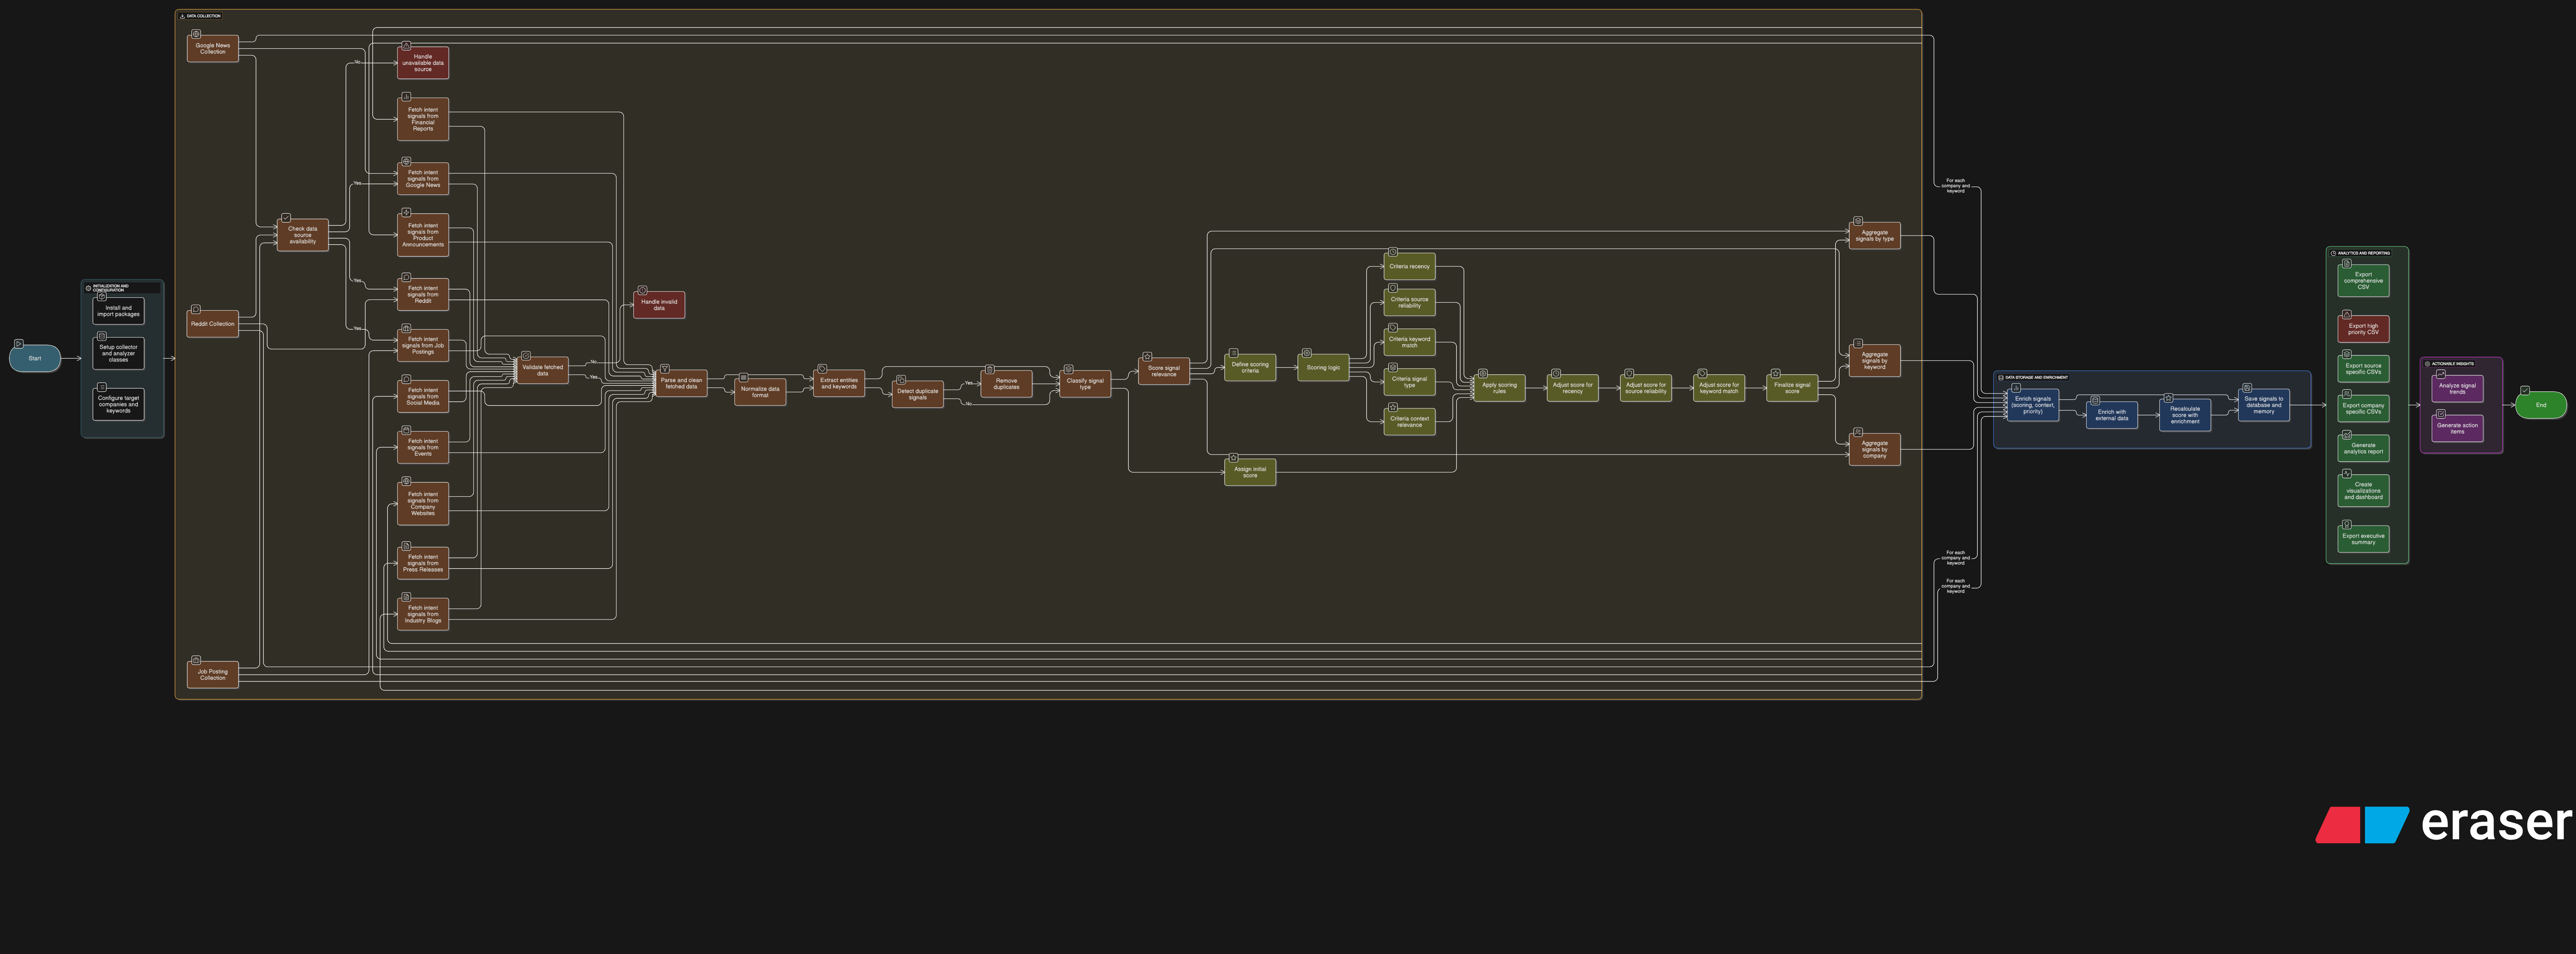

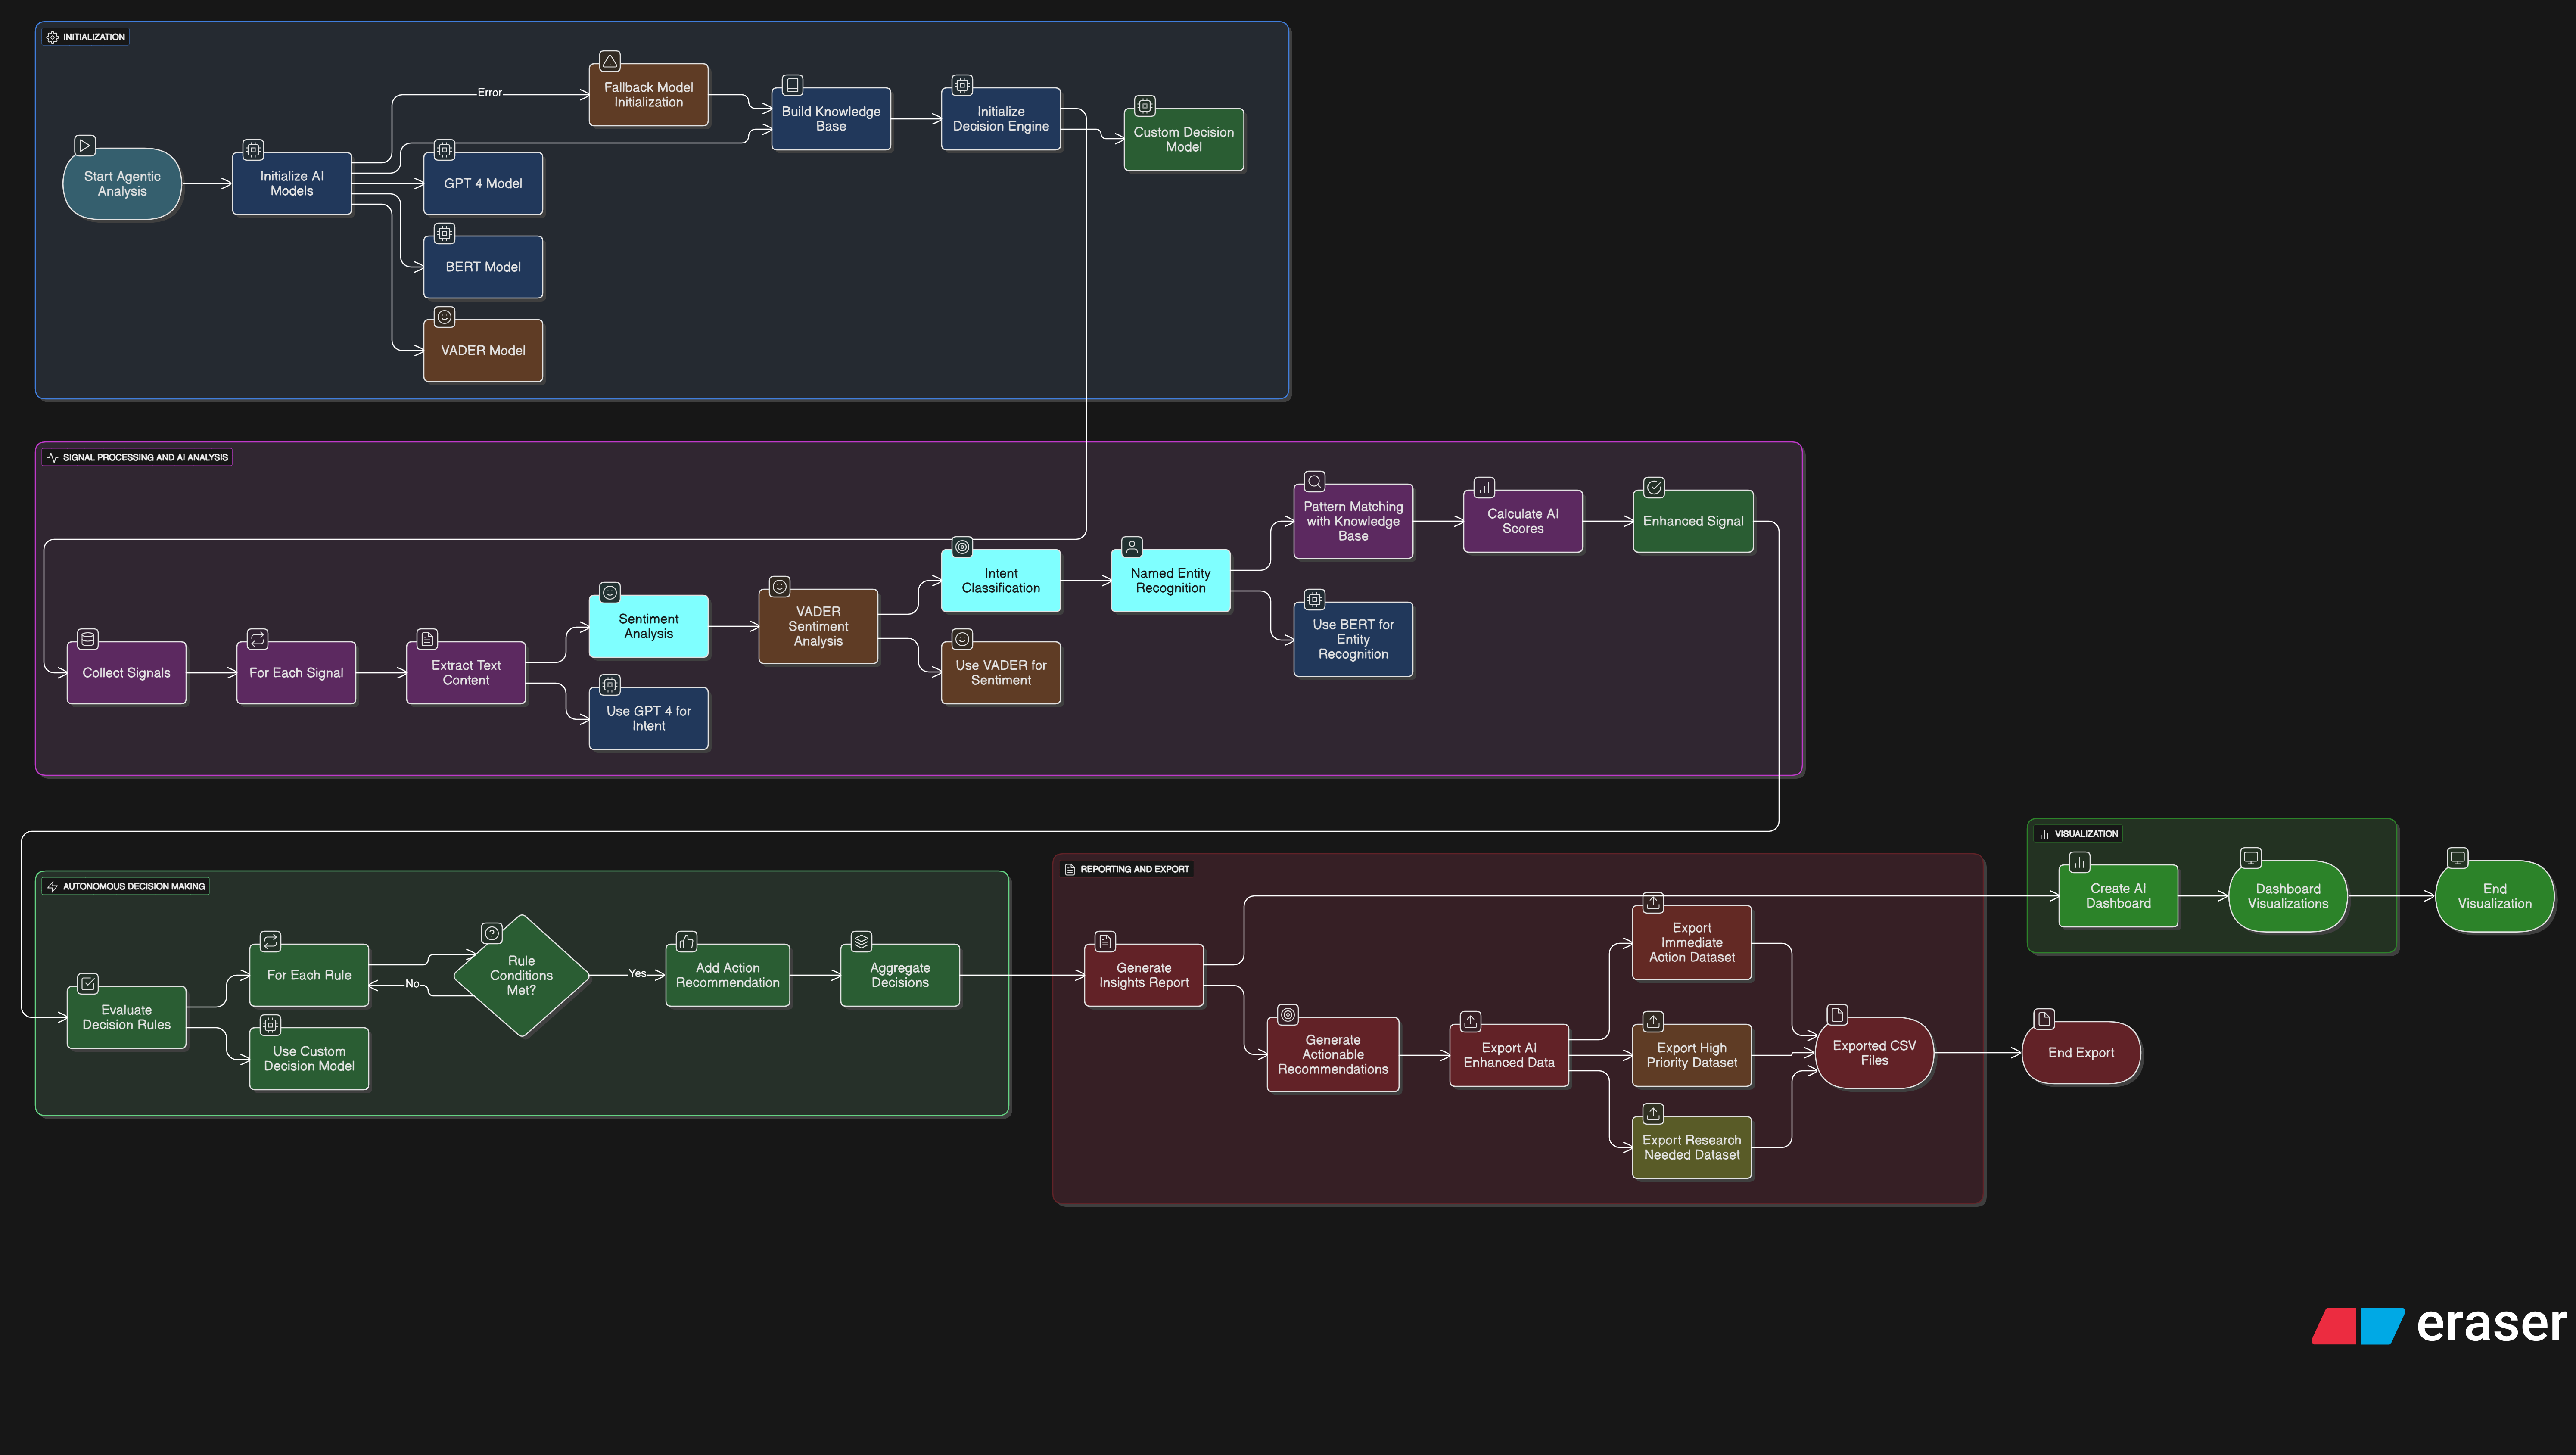

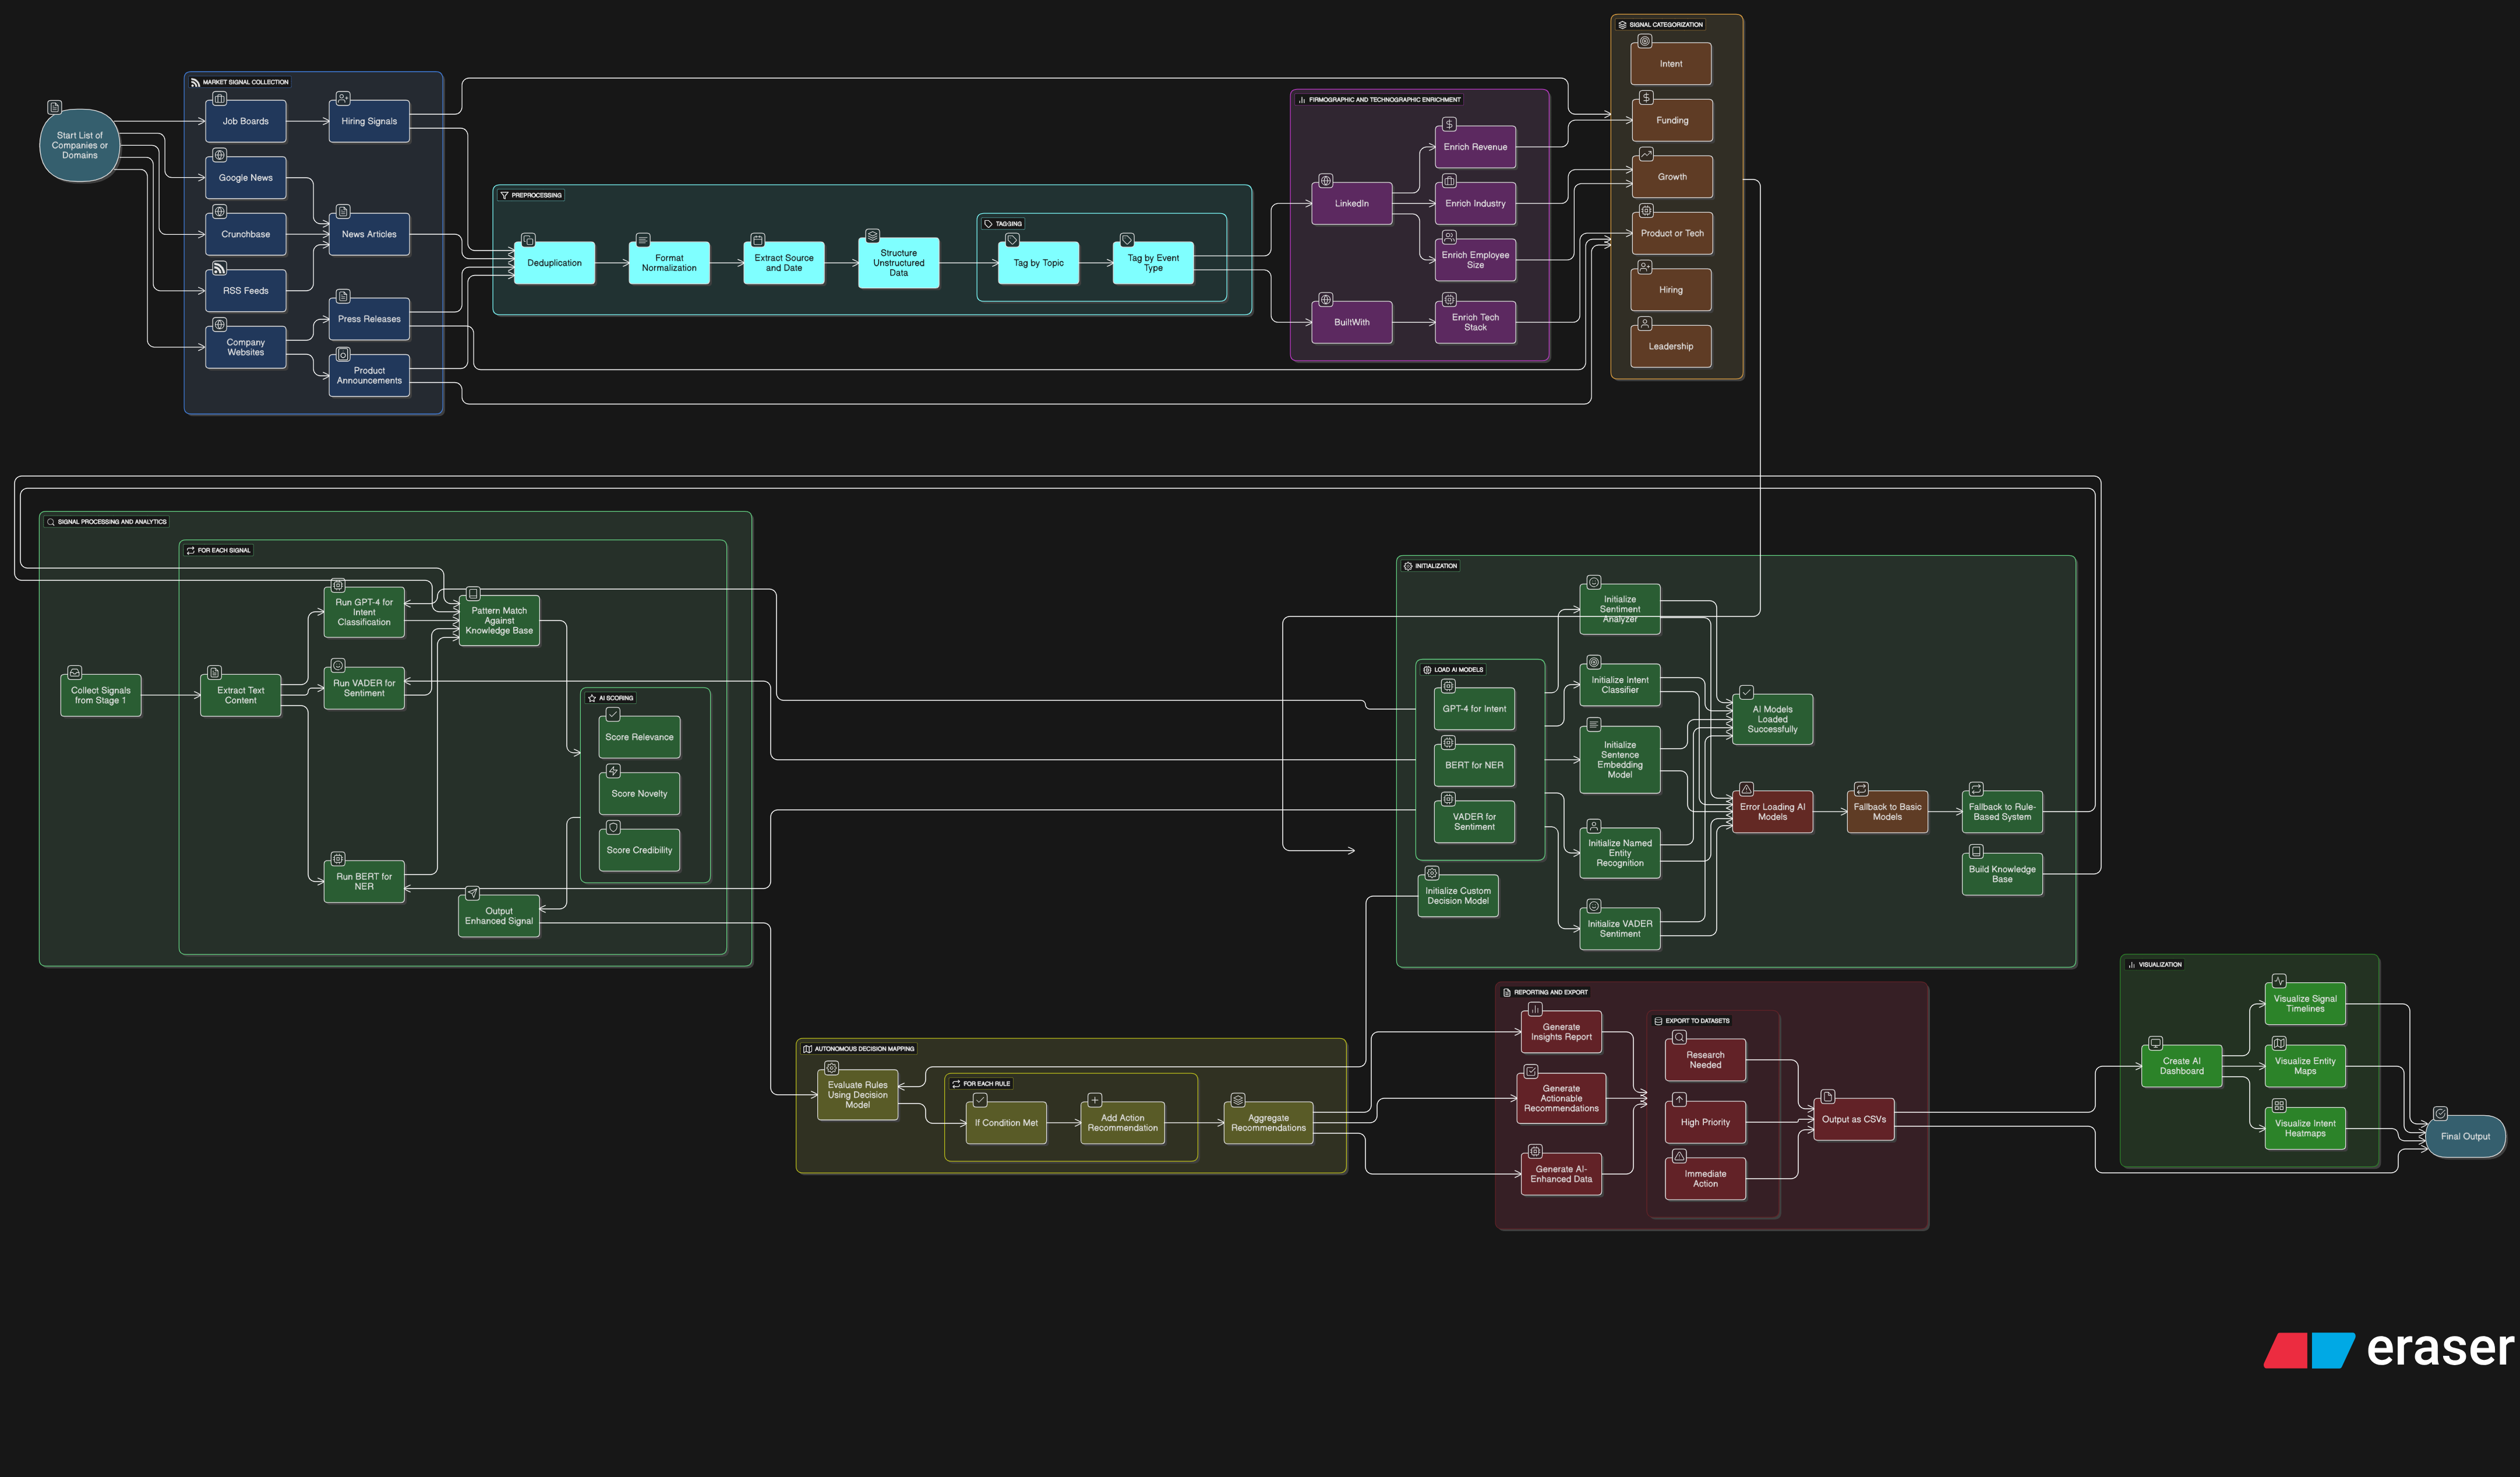

In [ ]:
csv1 = pd.read_csv("/content/executive_summary.csv")

In [ ]:
csv1